In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import Solver, Signal


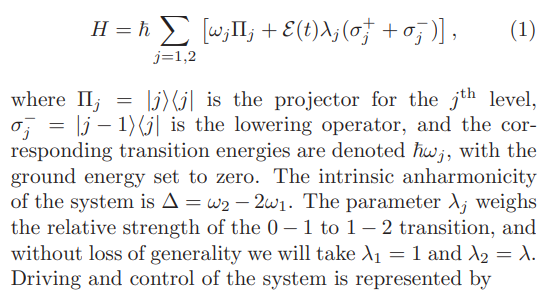

In [2]:
Omega_01 = 5.508 #Ghz
Delta = - 0.25
Omega_02 = 2*Omega_01 + Delta
Lambda = 0.08

ket0 = np.array([[1,0,0]]).T
ket1 = np.array([[0,1,0]]).T
ket2 = np.array([[0,0,1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

P0, P1, P2 = ket0 @ ket0.T.conj(), ket1 @ ket1.T.conj(), ket2 @ ket2.T.conj()


In [3]:
drift = 2 * np.pi * (Omega_01*P1 + Omega_02*P2)
control = [2 * np.pi * (sigma_p1 + sigma_m1 + Lambda*(sigma_p2 + sigma_m2))]
R_frame = 2 * np.pi * (Omega_01*P1 + 2*Omega_01*P2)
# drift, control, R_frame

In [4]:
y0 = Statevector([1., 0., 0.])
dt = 0.1
sigma = 5 #ns
T = 40 #ns
duration = np.math.ceil(T / dt)

amp = 0.5

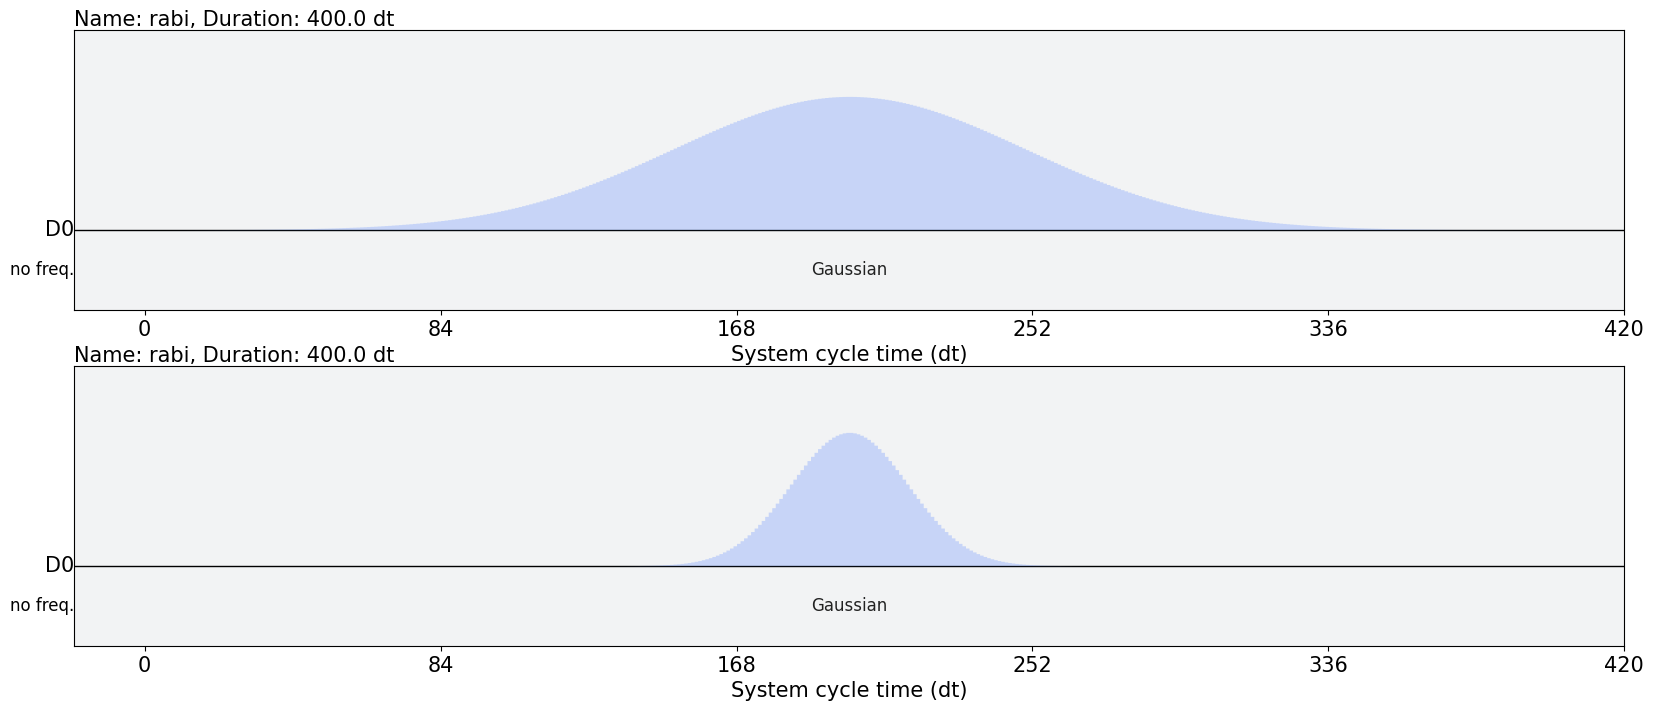

In [5]:
# signals = [Signal(envelope=1., carrier_freq=5.508)]
with pulse.build(name="rabi") as rb1:
    pulse.play(pulse.Gaussian(duration=duration, amp=amp, sigma=sigma / dt), pulse.DriveChannel(0))
with pulse.build(name="rabi") as rb2:
    pulse.play(pulse.Gaussian(duration=duration, amp=amp, sigma=sigma / dt / 3), pulse.DriveChannel(0))

_, (ax1, ax2) = plt.subplots(2,1, figsize=(20,8))  
rb1.draw(axis=ax1)
rb2.draw(axis=ax2)

In [6]:
# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
    rotating_frame=R_frame,
#     rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": Omega_01},
    dt=dt,
)

In [7]:
solutions = hamiltonian_solver.solve(t_span=[0., T], y0=y0, signals=[rb1, rb2])

In [8]:
plt.close()
fig, (axis1,axis2) = plt.subplots(2,2, figsize=(30,12))  

# rb1.draw(axis=axis1[0])
# rb2.draw(axis=axis1[1])

for ax, sol in zip(axis2, solutions):
    ax.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,0], label='0', linewidth=3)
    ax.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,1], label='1', linewidth=3)
    ax.plot(sol.t, np.array([psi.probabilities() for psi in sol.y])[:,2], label='2', linewidth=3)
    ax.set_xlabel("Time, t (ns)")
    ax.set_ylabel("Probabilities")
axis1[0].set_title("$\sigma$", y = 0.8, fontsize = 22)
axis1[1].set_title("$\sigma / 3$", y = 0.8, fontsize = 22)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)

fig.suptitle("Rabi Oscillations", x = 0.51, y=.99, fontsize = 25)
fig.text(0.37, 0.92,
    (
    "$\omega_{01} = 5.508 GHz$    "+
    "$\Delta = -0.25 GHz$    "+
    f"$\lambda = {Lambda} GHz$    "+
    "$dt = 0.1 ns$    "+
    "$amp = 0.5$    "+
    "$\sigma = 5 ns$"
    ),
    backgroundcolor = 'lightcyan'
)

rb1.draw(axis=axis1[0])
rb2.draw(axis=axis1[1])

fig.savefig("Rabi std comparison2.pdf")